### Import packages

In [1]:
# using Kernel PyTorch-2.0.1
# python 
import sys
import os
import datetime

# basics 
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import sklearn
import torch
import torch_geometric

In [2]:
# check the version
# print("pandas version: " + pd.__version__)
print("numpy version: " + np.__version__)
print("Sklearn version: " + sklearn.__version__)
# print("Seaborn version: " + sns.__version__)
print("PyTorch version: " + torch.__version__)
print("PyG version: " + torch_geometric.__version__)

numpy version: 1.24.3
Sklearn version: 1.2.2
PyTorch version: 2.0.1
PyG version: 2.3.0


### test PyG

In [3]:
from torch_geometric.data import Data
x = torch.tensor([[2,1],[5,6],[3,7],[12,0]],dtype=torch.float)
y = torch.tensor([0,1,0,1], dtype=torch.float)
edge_index = torch.tensor([[0,1,2,0,3],
                          [1,0,1,3,2]],dtype=torch.long)
mydata = Data(x=x,y=y,edge_index=edge_index)
mydata

Data(x=[4, 2], edge_index=[2, 5], y=[4])

In [33]:
# Helper function for visualization.
#%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [55]:
from sklearn.manifold import TSNE
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

### Introduction of GNNs
**Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts 
to irregular structured data (in contrast to images or texts) and 
to enable neural networks to reason about objects and their relations.

PyTorch Geometric provides an easy access to this dataset via the `torch_geometric.datasets` subpackage

Zachary's karate club network graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

In [46]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


After initializing the KarateClub dataset, we first can inspect some of its properties. For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club). Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [47]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [48]:
data.x[10:20]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [49]:
data.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

The graph connectivity (edge index) should be confined with the **COO format (coordinate format)**, 
i.e. the first list contains the index of the source nodes, while the index of target nodes is specified in the second list.

In [50]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [51]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

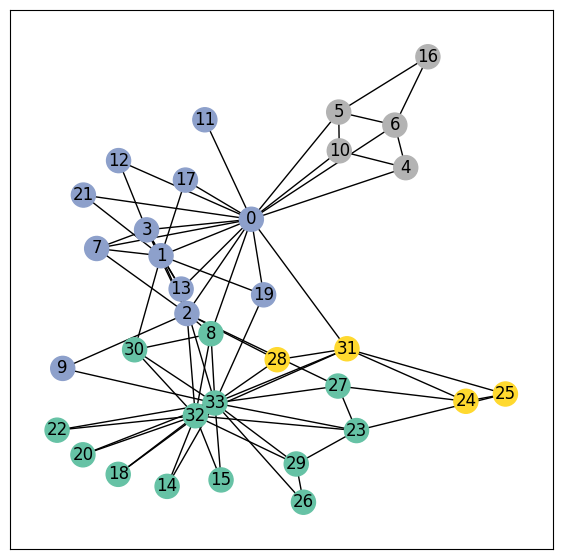

In [34]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

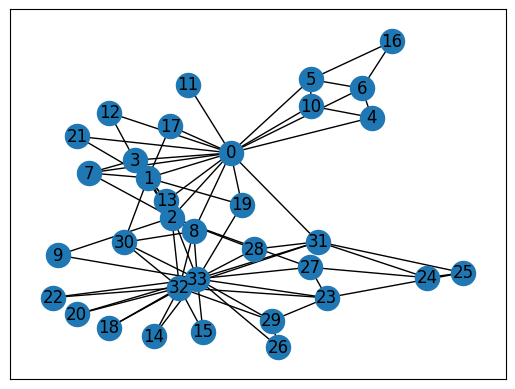

In [37]:
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42))

In [9]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


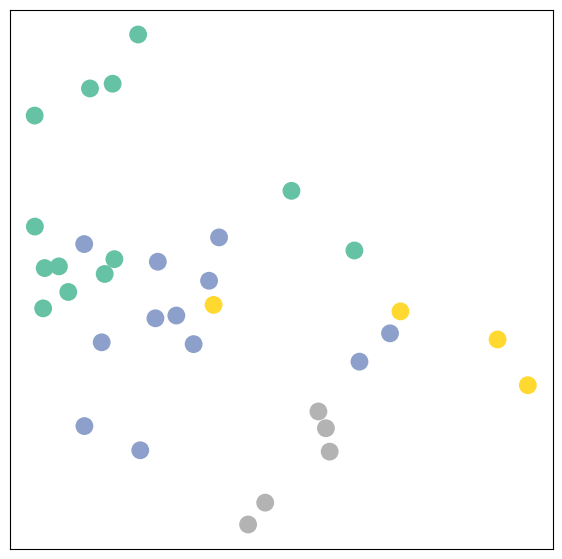

In [53]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

In [39]:
len(h)

34

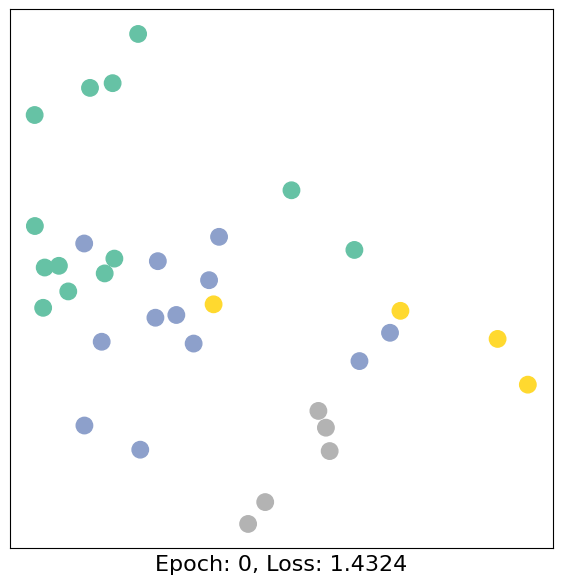

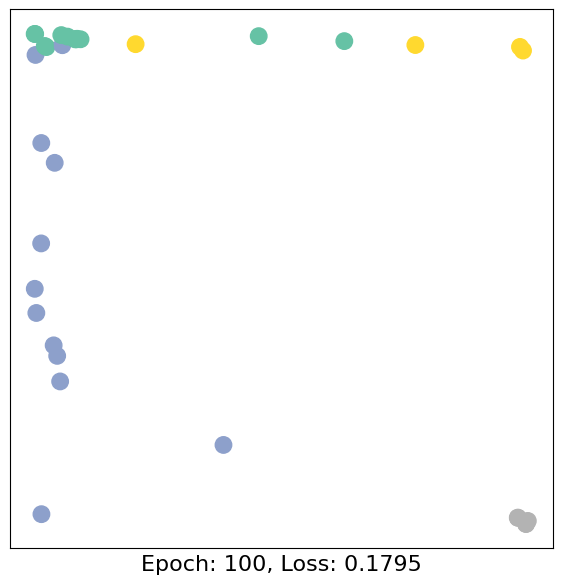

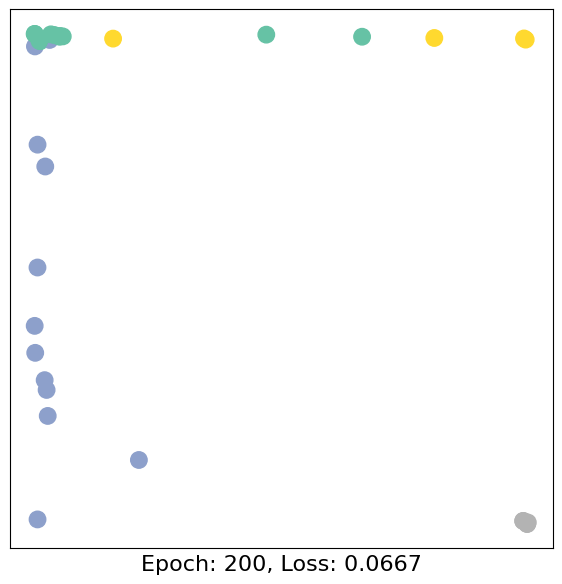

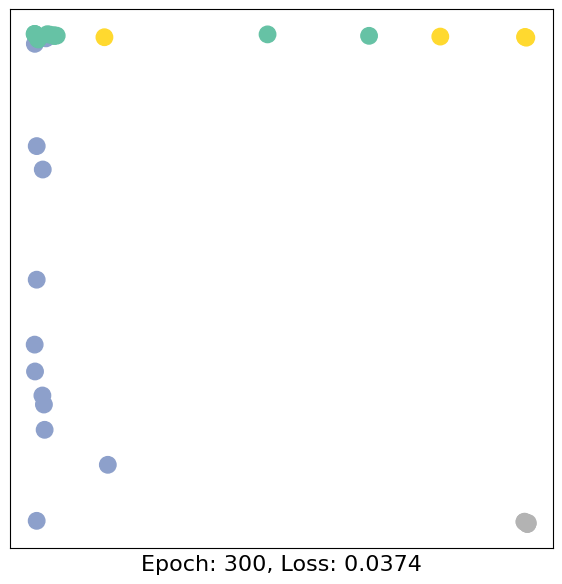

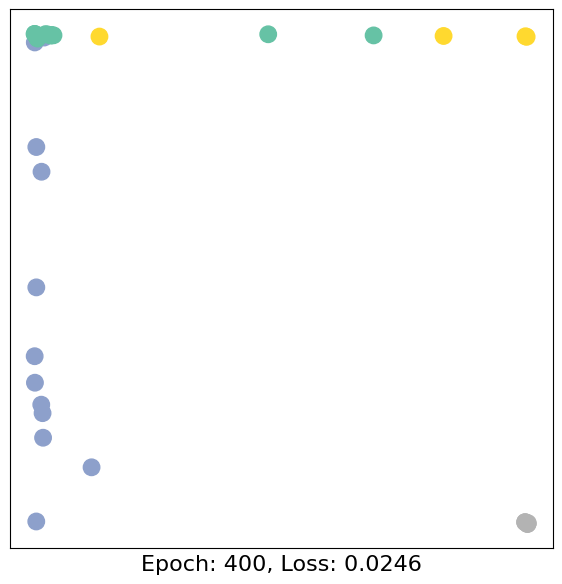

In [12]:
import time
from IPython.display import Javascript  # Restrict height of output cell.

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 100 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

The network is trained using a loss function that encourages the vectors for similar nodes to be close together and the vectors for dissimilar nodes to be far apart. 3-layer GCN model manages to linearly separating the communities and classifying most of the nodes correctly.

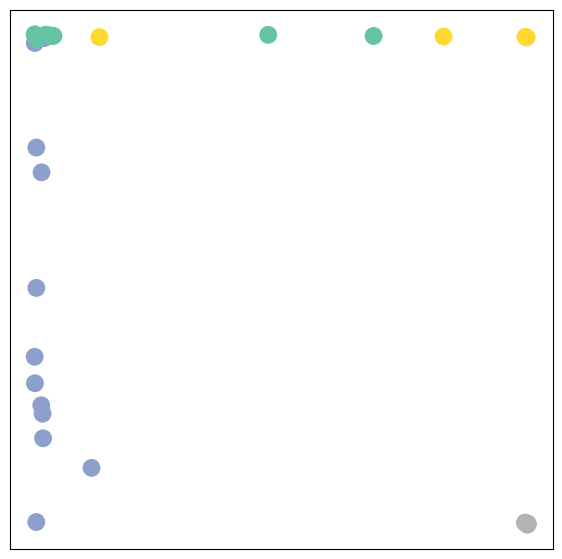

In [42]:
visualize_embedding(h, color=data.y)